___
# Countries Notebook
### This notebook includes all our data analysis work involving Countries in general.
___

In [11]:
!pip install pycountry-convert
!pip install factor_analyzer
!pip install xlrd
!pip install openpyxl

     |████████████████████████████████| 243 kB 5.5 MB/s eta 0:00:01


In [52]:
#Importing the needed libraries.
import os
import pandas as pd
import utility as util
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pycountry_convert import country_name_to_country_alpha3 # for choropleth maps
import seaborn as sns
import plotly.figure_factory as ff
from factor_analyzer.factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
n = 10

___

In [53]:
#Implementing our Data set.
worksheets = pd.ExcelFile('../../data/BU-UG/BU-UG-FYP.xlsx')
worksheets.sheet_names

worksheet = {}
for ws_name in worksheets.sheet_names:
    worksheet[ws_name] = pd.read_excel('../../data/BU-UG/BU-UG-FYP.xlsx', sheet_name = ws_name)

In [54]:
#Creating dataframes for our analysis.
df_country = worksheet['countries']
df_vulnerabilities = worksheet['cves']

df_country_IMD = df_country[['country','totalcount','overall_performance','factor_knowledge',
                             'factor_technology','factor_future_readiness','subfact_know_talent',
                             'subfact_know_training_education','subfact_know_scientific_concentration',
                             'subfact_tech_regulatory_framework','subfact_tech_capital',
                             'subfact_tech_technological_framework','subfact_fr_adaptive_attitudes',
                             'subfact_fr_business_agility','subfact_fr_it_integration']]

___
# Factor and Clustering Analysis

In [55]:
colnames=df_country.columns.tolist()
cverange = [colnames.index(l) for l in colnames if l.startswith('CVE-')]

In [56]:
df_pivot=df_country[df_country.totalcount>4500000].iloc[:,np.r_[0:1,min(cverange):max(cverange)+2]].T # top10 with the most potential vulnerabilities
df_pivot=df_pivot.rename(columns=df_pivot.iloc[0])
df_pivot=df_pivot.drop(df_pivot.index[0])
df_pivot

,BR,CA,CN,FR,DE,HK,JP,RU,GB,US
CVE-2017-1000369,287,1976,1482,9235,6871,683,490,17811,2581,8707
CVE-2017-1000600,507,1231,691,1609,6580,302,5259,961,1239,18355
CVE-2017-1001000,34,41,23,97,95,7,220,33,65,801
CVE-2017-10140,9,9,1,11,0,0,9,13,1,19
CVE-2017-10391,56,4,6,12,17,2,2,5,5,182
...,...,...,...,...,...,...,...,...,...,...
CVE-2020-11651,0,0,6,4,3,2,0,2,4,13
CVE-2020-11652,0,0,6,4,3,2,0,2,4,13
CVE-2020-1938,1064,518,15249,927,1651,460,932,335,683,5360
CVE-2020-5902,5,12,13,2,1,1,8,0,7,126


## Factor Analysis

In [57]:
# from https://stackoverflow.com/questions/20799403/improving-performance-of-cronbach-alpha-code-python-numpy
# define Chronbach's alpha - this code is not computationally efficient, use with care

def svar(X):
    n = float(len(X))
    svar=(sum([(x-np.mean(X))**2 for x in X]) / n)* n/(n-1.)
    return svar


def CronbachAlpha(itemscores):
    itemvars = [svar(item) for item in itemscores]
    tscores = [0] * len(itemscores[0])
    for item in itemscores:
       for i in range(len(item)):
          tscores[i]+= item[i]
    nitems = len(itemscores)
    #print "total scores=", tscores, 'number of items=', nitems

    Calpha=nitems/(nitems-1.) * (1-sum(itemvars)/ svar(tscores))

    return Calpha

In [58]:
### Factor analysis
for i in df_pivot.columns:
    df_pivot[i]=df_pivot[i].astype(float)
chi_square_value,p_value=calculate_bartlett_sphericity(df_pivot)
print(chi_square_value, p_value, ('not significant', 'significant')[p_value<0.05])

8299.899101431234 0.0 significant


In [59]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation='varimax')
f=fa.fit(df_pivot)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print('number of factors:',f.n_factors)

number of factors: 3


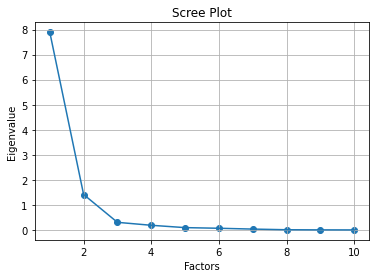

In [60]:
# Confirm graphically the number of factors (i.e. where Eigenvalue>1)
plt.scatter(range(1,df_pivot.shape[1]+1),ev)
plt.plot(range(1,df_pivot.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [61]:
# create correlation matrix and loadings matrix as dataframes
res_correlation=pd.DataFrame(fa.corr_,columns=df_pivot.columns, index=df_pivot.columns)
res_loadings=pd.DataFrame(fa.loadings_,columns=['factor_' + str(i) for i in range(1,fa.n_factors+1)], index=df_pivot.columns)
res_loadings2=res_loadings.copy()
cols=res_loadings.columns
res_loadings['max']=res_loadings[cols].max(axis=1)
for i in cols:
    res_loadings[i]=np.where(res_loadings[i]==res_loadings['max'],res_loadings['max'],'')
del(res_loadings['max'])
res_loadings #resloadings2 for original

,factor_1,factor_2,factor_3
BR,0.8019662089460878,,
CA,,0.7231847076351283,
CN,,0.9533642500943863,
FR,0.973088205448847,,
DE,0.9394279217126674,,
HK,,0.8408919509933828,
JP,0.6963098978560363,,
RU,0.8732566879712462,,
GB,0.8298668188650092,,
US,,,0.6368979159411632


In [62]:
# #Cronbach's alpha to check internal structures of groups

# for i in res_loadings.columns:
#     itemlist=res_loadings.index[res_loadings[i]!=''].tolist()
#     items=df_pivot[itemlist].T
#     itemscores=np.ndarray.tolist(items.values)
#     print(i,':',itemlist,"\nCronbach's alpha:", CronbachAlpha(itemscores)) #ZeroDivisionError: float division by zero

___
## Clustering

In [63]:
fig = ff.create_dendrogram(df_pivot.T, labels=df_pivot[0:].columns, color_threshold=4000000)
fig.show()

___

In [64]:
Y = df_country_IMD.nlargest(10, ['totalcount'])
Y

,country,totalcount,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,subfact_know_scientific_concentration,subfact_tech_regulatory_framework,subfact_tech_capital,subfact_tech_technological_framework,subfact_fr_adaptive_attitudes,subfact_fr_business_agility,subfact_fr_it_integration
235,United States of America,62138431,1.0,1.0,7.0,2.0,14.0,24.0,1.0,22.0,1.0,7.0,3.0,2.0,10.0
45,China,19302643,16.0,8.0,27.0,18.0,13.0,40.0,2.0,18.0,31.0,32.0,17.0,4.0,35.0
81,Germany,12631361,18.0,12.0,31.0,19.0,22.0,17.0,5.0,28.0,16.0,45.0,23.0,15.0,20.0
110,Japan,9732132,27.0,22.0,26.0,26.0,46.0,15.0,11.0,44.0,33.0,5.0,19.0,56.0,23.0
98,Hong Kong,9506773,5.0,7.0,2.0,10.0,7.0,5.0,17.0,7.0,12.0,2.0,4.0,14.0,19.0
75,France,9432648,24.0,20.0,15.0,31.0,25.0,36.0,13.0,9.0,20.0,19.0,36.0,36.0,21.0
39,Canada,7236864,12.0,5.0,13.0,15.0,8.0,6.0,7.0,12.0,3.0,26.0,16.0,16.0,13.0
232,United Kingdom,6082186,13.0,13.0,16.0,13.0,10.0,25.0,8.0,17.0,22.0,22.0,11.0,25.0,11.0
177,Russia,5470802,43.0,26.0,47.0,53.0,47.0,13.0,24.0,40.0,57.0,41.0,43.0,60.0,51.0
29,Brazil,4829744,51.0,57.0,57.0,43.0,62.0,61.0,27.0,52.0,58.0,50.0,39.0,41.0,48.0


In [65]:
Y = Y.iloc[:, [1,2]].values # totalcount and gini_value
Y

array([[6.2138431e+07, 1.0000000e+00],
       [1.9302643e+07, 1.6000000e+01],
       [1.2631361e+07, 1.8000000e+01],
       [9.7321320e+06, 2.7000000e+01],
       [9.5067730e+06, 5.0000000e+00],
       [9.4326480e+06, 2.4000000e+01],
       [7.2368640e+06, 1.2000000e+01],
       [6.0821860e+06, 1.3000000e+01],
       [5.4708020e+06, 4.3000000e+01],
       [4.8297440e+06, 5.1000000e+01]])

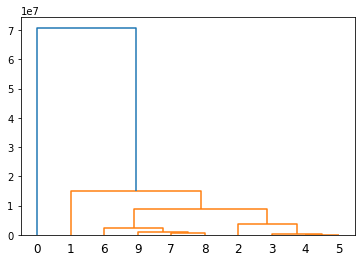

In [66]:
dendogram = sch.dendrogram(sch.linkage(Y, method = "ward"))

In [67]:
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage='ward')
y_hc=hc.fit_predict(Y)

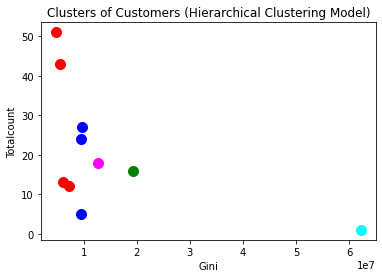

In [68]:
plt.scatter(Y[y_hc==0, 0], Y[y_hc==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(Y[y_hc==1, 0], Y[y_hc==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(Y[y_hc==2, 0], Y[y_hc==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(Y[y_hc==3, 0], Y[y_hc==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(Y[y_hc==4, 0], Y[y_hc==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.title('Clusters of Customers (Hierarchical Clustering Model)')
plt.xlabel('Gini')
plt.ylabel('Totalcount')
plt.show()

In [72]:
df_GCI = util.tidy_split(df_country,column='GCI',sep=',')
df_GCI=df_GCI[df_GCI['GCI']!='nan']
df_GCI.head(5)

,country_code,country,population_2020,GCI,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,...,CVE-2019-9712,CVE-2019-9713,CVE-2019-9714,CVE-2019-9787,CVE-2020-0796,CVE-2020-11651,CVE-2020-11652,CVE-2020-1938,CVE-2020-5902,MS17-010
12,AU,Australia,25500000.0,0.765,15.0,17.0,14.0,17.0,6.0,28.0,...,0,0,0,1093,644,1,1,114,8,279
13,AT,Austria,9006000.0,0.676,17.0,11.0,28.0,16.0,12.0,12.0,...,0,0,0,139,284,1,1,52,0,14
29,BR,Brazil,212559000.0,0.706,51.0,57.0,57.0,43.0,62.0,61.0,...,0,0,0,766,2210,0,0,1064,5,194
39,CA,Canada,37742000.0,0.794,12.0,5.0,13.0,15.0,8.0,6.0,...,0,0,0,2008,1403,0,0,518,12,112
67,EE,Estonia,1327000.0,0.706,21.0,23.0,23.0,20.0,31.0,3.0,...,0,0,0,89,52,0,0,13,0,0


In [87]:
M = df_SP.iloc[:, [0,1]].values # totalcount and gini_value

In [88]:
df_SP = df_GCI[["GCI", "gini_value"]]

In [96]:
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage='ward')
y_hc=hc.fit_predict(M)

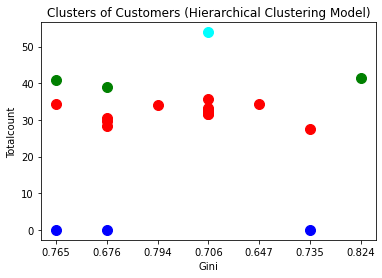

In [97]:
plt.scatter(M[y_hc==0, 0], M[y_hc==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(M[y_hc==1, 0], M[y_hc==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(M[y_hc==2, 0], M[y_hc==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(M[y_hc==3, 0], M[y_hc==3, 1], s=100, c='cyan', label ='Cluster 4')
#plt.scatter(df_SP[y_hc==4, 0], df_SP[y_hc==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.title('Clusters of Customers (Hierarchical Clustering Model)')
plt.xlabel('Gini')
plt.ylabel('Totalcount')
plt.show()

___

In [69]:
top10 = df_country.nlargest(10, ['totalcount'])

fig = px.bar(top10, x='totalcount', y='country',
             hover_data=['country', 'totalcount'], orientation='h',
              height=500)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_layout(title='Top 10 Exposed Countries',
                  xaxis = dict(title='Exposure'),
                  yaxis = dict(title='Country'))
fig.show()

In [70]:
top10 = df_country.nlargest(10, ['population_2020'])

fig = px.bar(top10, x='population_2020', y='country',
             hover_data=['country', 'population_2020'], orientation='h',
              height=500)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

fig.update_layout(title='Top 10 Populated Countries',
                  xaxis = dict(title='Population'),
                  yaxis = dict(title='Country'))
fig.show()

___
## Population and Exposure Comparison 

In [30]:
df_population_exposure = df_country[['country','totalcount','population_2020']]
df_population_exposure = df_population_exposure.nlargest(10, ['population_2020'])
df_population_exposure['totalper1k']=df_population_exposure.totalcount/(df_population_exposure.population_2020/1000)

In [31]:
df_population_exposure

,country,totalcount,population_2020,totalper1k
45,China,19302643,1.439324e+09,13.410909
101,India,3929926,1.380004e+09,2.847764
235,United States of America,62138431,3.310030e+08,187.727697
102,Indonesia,1980819,2.735240e+08,7.241847
163,Pakistan,187975,2.208920e+08,0.850981
29,Brazil,4829744,2.125590e+08,22.721898
155,Nigeria,56776,2.061400e+08,0.275424
17,Bangladesh,202889,1.646890e+08,1.231952
177,Russia,5470802,1.459340e+08,37.488193
139,Mexico,696502,1.289330e+08,5.402046


Text(0, 0.5, '')

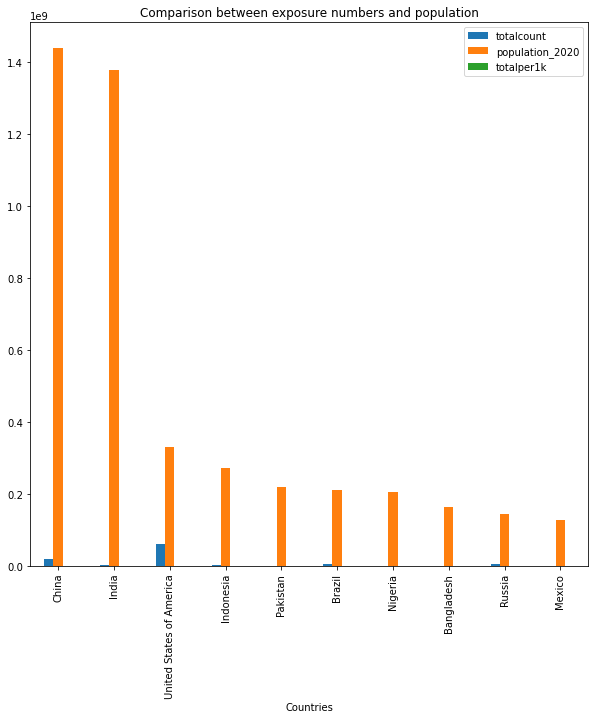

In [32]:
df_plot=df_population_exposure
#del df_plot['population_2020']
df_plot.plot(kind='bar', 
             stacked=False,
             x="country",
             figsize=(10,10))

plt.title("Comparison between exposure numbers and population")
plt.xlabel("Countries")
plt.ylabel("")

In [33]:
df_country[['country','totalcount','population_2020']]

,country,totalcount,population_2020
0,Afghanistan,6668,38928000.0
1,Aland Islands,2219,29013.0
2,Albania,36735,2878000.0
3,Algeria,36146,43851000.0
4,American Samoa,503,55000.0
...,...,...,...
242,Wallis and Futuna,93,11000.0
243,Western Sahara,0,597000.0
244,Yemen,3554,29826000.0
245,Zambia,11319,18384000.0


___
## Gini Value

In [34]:
#see if there is any corelation between gini value and total vulnerabilities
df_country['gini_value'].corr(df_country['totalcount'])

0.09625949577003733

<AxesSubplot:xlabel='gini_value', ylabel='totalcount'>

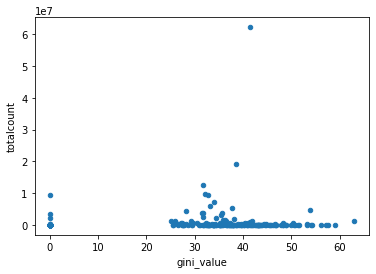

In [35]:
df_country.plot.scatter(x='gini_value',y='totalcount')

From the above there is no correlation between the distribution of wealth (according to Gini index) and number of vlunerabilities

In [36]:
top_gdp = df_country.loc[df_country['country'].isin(['United Kingdom','Austria','Hong Kong','United Arab Emirates','Norway','Singapore','Denmark','Sweden','Switzerland','Netherlands','South Korea','Finland','Taiwan','Taiwan','Canada','Australia','Germany','Estonia','Israel','Ireland','New Zealand','Iceland','France','Belgium','Japan','Saudi Arabia','Luxembourg','Qatar','Slovenia','Spain','Saudi Arabia','Czech Republic','Portugal','Cyprus','Italy'])]
bottom_gdp = df_country.loc[df_country['country'].isin(['China','Malyasia','Lithuania','Poland','Kazakhstan','Latvia','Thailand','Chile','Russia','Turkey','Bulgaria','Greece','Hungary','India','Romania','Slovak Republic','Brazil','Croatia','Jordan','Mexico','Peru','Indonesia','Philippines','Ukraine','Argentina','South Africa','Colombia','Mongolia'])]


top_gdp[['country', 'totalcount']].head(5)

,country,totalcount
12,Australia,2216473
13,Austria,644325
20,Belgium,675262
39,Canada,7236864
56,Cyprus,138146


In [37]:
bottom_gdp[['country', 'totalcount']].head(5)

,country,totalcount
9,Argentina,1001855
29,Brazil,4829744
33,Bulgaria,595942
44,Chile,366805
45,China,19302643


In [38]:
top10 = top_gdp.nlargest(10, ['totalcount'])

fig = px.bar(top10, x='totalcount', y='country',
             hover_data=['country', 'totalcount'], orientation='h',
              height=500)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_layout(title='',
                  xaxis = dict(title='Exposure'),
                  yaxis = dict(title='Country'))
fig.show()

In [39]:
top10 = bottom_gdp.nlargest(10, ['totalcount'])

fig = px.bar(top10, x='totalcount', y='country',
             hover_data=['country', 'totalcount'], orientation='h',
              height=500)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_layout(title='',
                  xaxis = dict(title='Exposure'),
                  yaxis = dict(title='Country'))
fig.show()

___
## Choropleth Maps

In [40]:
 def get_iso(col): 
    try:
        iso_3 =  country_name_to_country_alpha3(col)
    except:
        iso_3 = 'Unknown'
    return iso_3

df_country['iso_alpha'] = df_country['country'].apply(lambda x: get_iso(x))

import warnings
warnings.filterwarnings('ignore')
df_country['iso_alpha'].loc[df_country['country'] == "The Democratic Republic of the Congo"] = 'COD'
df_country['iso_alpha'].loc[df_country['country'] == "Czech Republic"] = 'CZE'
df_country['iso_alpha'].loc[df_country['country'] == "Palestine"] = 'PSE'

In [41]:
fig = px.choropleth(df_country, locations="iso_alpha",
                    color="population_2020",
                    hover_name="country")#,
#                    color_continuous_scale='Viridis_r')
fig.update_layout(title_text="World population in 2020")
fig.show()

In [42]:
fig = px.choropleth(df_country, locations="iso_alpha",
                    color="totalcount",
                    hover_name="country")#,
#                    color_continuous_scale='Viridis_r')
fig.update_layout(title_text="World population in 2020")
fig.show()

___
# IMD

In [43]:
df_country_IMD = df_country_IMD[df_country_IMD['overall_performance'].notnull()]
df_country_IMD.head(5)

,country,totalcount,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,subfact_know_scientific_concentration,subfact_tech_regulatory_framework,subfact_tech_capital,subfact_tech_technological_framework,subfact_fr_adaptive_attitudes,subfact_fr_business_agility,subfact_fr_it_integration
9,Argentina,1001855,59.0,50.0,62.0,47.0,56.0,43.0,55.0,57.0,62.0,56.0,49.0,39.0,52.0
12,Australia,2216473,15.0,17.0,14.0,17.0,6.0,28.0,19.0,6.0,13.0,20.0,5.0,43.0,12.0
13,Austria,644325,17.0,11.0,28.0,16.0,12.0,12.0,14.0,24.0,30.0,33.0,21.0,21.0,9.0
20,Belgium,675262,25.0,21.0,19.0,25.0,20.0,31.0,21.0,19.0,21.0,29.0,24.0,35.0,26.0
29,Brazil,4829744,51.0,57.0,57.0,43.0,62.0,61.0,27.0,52.0,58.0,50.0,39.0,41.0,48.0


In [44]:
top10_IMD_countries = df_country_IMD.nlargest(10, ['totalcount'])
del top10_IMD_countries['totalcount']
top10_IMD_countries

,country,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,subfact_know_scientific_concentration,subfact_tech_regulatory_framework,subfact_tech_capital,subfact_tech_technological_framework,subfact_fr_adaptive_attitudes,subfact_fr_business_agility,subfact_fr_it_integration
235,United States of America,1.0,1.0,7.0,2.0,14.0,24.0,1.0,22.0,1.0,7.0,3.0,2.0,10.0
45,China,16.0,8.0,27.0,18.0,13.0,40.0,2.0,18.0,31.0,32.0,17.0,4.0,35.0
81,Germany,18.0,12.0,31.0,19.0,22.0,17.0,5.0,28.0,16.0,45.0,23.0,15.0,20.0
110,Japan,27.0,22.0,26.0,26.0,46.0,15.0,11.0,44.0,33.0,5.0,19.0,56.0,23.0
98,Hong Kong,5.0,7.0,2.0,10.0,7.0,5.0,17.0,7.0,12.0,2.0,4.0,14.0,19.0
75,France,24.0,20.0,15.0,31.0,25.0,36.0,13.0,9.0,20.0,19.0,36.0,36.0,21.0
39,Canada,12.0,5.0,13.0,15.0,8.0,6.0,7.0,12.0,3.0,26.0,16.0,16.0,13.0
232,United Kingdom,13.0,13.0,16.0,13.0,10.0,25.0,8.0,17.0,22.0,22.0,11.0,25.0,11.0
177,Russia,43.0,26.0,47.0,53.0,47.0,13.0,24.0,40.0,57.0,41.0,43.0,60.0,51.0
29,Brazil,51.0,57.0,57.0,43.0,62.0,61.0,27.0,52.0,58.0,50.0,39.0,41.0,48.0


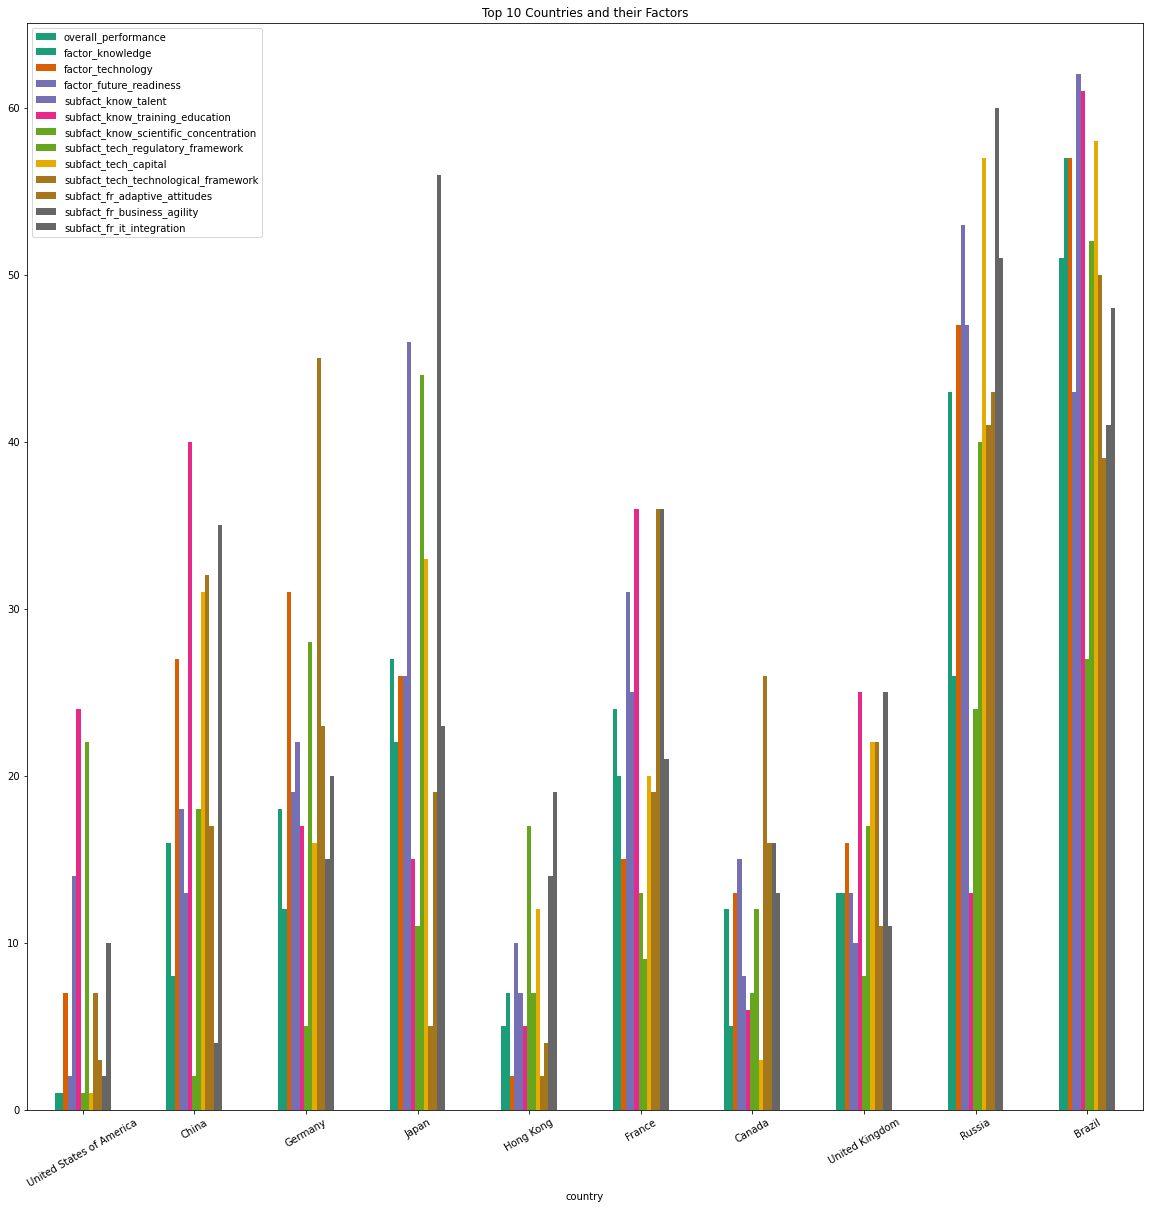

In [45]:
top10_IMD_countries.plot(kind='bar',
                         x="country",
                         title='Top 10 Countries and their Factors',
                         cmap='Dark2',
                         stacked=False, 
                         figsize=(20,20),
                         rot=30);

___
## Factors

In [46]:
df_above_25=df_country_IMD
df_above_25=df_above_25[(df_above_25.overall_performance<25.0) & 
              (df_above_25.factor_knowledge<25.0) &
              (df_above_25.factor_technology<25.0) & 
              (df_above_25.factor_future_readiness<25.0) &
              (df_above_25.subfact_know_talent<25.0) &
              (df_above_25.subfact_know_training_education<25.0) &
              (df_above_25.subfact_know_scientific_concentration<25.0) &
              (df_above_25.subfact_tech_regulatory_framework<25.0) &
              (df_above_25.subfact_tech_capital<25.0) &
              (df_above_25.subfact_tech_technological_framework<25.0) &
              (df_above_25.subfact_fr_adaptive_attitudes<25.0) &
              (df_above_25.subfact_fr_business_agility<25.0) &
              (df_above_25.subfact_fr_it_integration<25.0)]

In [47]:
df_above_25

,country,totalcount,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,subfact_know_scientific_concentration,subfact_tech_regulatory_framework,subfact_tech_capital,subfact_tech_technological_framework,subfact_fr_adaptive_attitudes,subfact_fr_business_agility,subfact_fr_it_integration
58,Denmark,235513,3.0,6.0,9.0,1.0,4.0,9.0,15.0,4.0,23.0,6.0,2.0,5.0,1.0
74,Finland,702147,10.0,15.0,10.0,9.0,11.0,20.0,12.0,13.0,6.0,10.0,10.0,22.0,2.0
98,Hong Kong,9506773,5.0,7.0,2.0,10.0,7.0,5.0,17.0,7.0,12.0,2.0,4.0,14.0,19.0
194,Singapore,3597559,2.0,2.0,1.0,12.0,1.0,7.0,10.0,1.0,11.0,1.0,20.0,11.0,3.0
210,Sweden,1333328,4.0,4.0,6.0,7.0,9.0,2.0,6.0,5.0,4.0,11.0,8.0,10.0,4.0
211,Switzerland,746935,6.0,3.0,11.0,5.0,2.0,14.0,9.0,10.0,14.0,14.0,9.0,6.0,7.0
213,Taiwan,2090364,11.0,18.0,5.0,8.0,18.0,21.0,18.0,16.0,8.0,4.0,14.0,1.0,17.0
235,United States of America,62138431,1.0,1.0,7.0,2.0,14.0,24.0,1.0,22.0,1.0,7.0,3.0,2.0,10.0


In [48]:
top10 = df_above_25.nlargest(10, ['totalcount'])

fig = px.bar(top10, x='totalcount', y='country',
             hover_data=['country', 'totalcount'], orientation='h',
              height=500)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_layout(title='',
                  xaxis = dict(title='Exposure'),
                  yaxis = dict(title='Country'))
fig.show()

___

In [49]:
df_below_25=df_country_IMD
df_below_25=df_below_25[(df_below_25.overall_performance>25.0) & 
              (df_below_25.factor_knowledge>25.0) &
              (df_below_25.factor_technology>25.0) & 
              (df_below_25.factor_future_readiness>25.0) &
              (df_below_25.subfact_know_talent>25.0) &
              (df_below_25.subfact_know_training_education>25.0) &
              (df_below_25.subfact_know_scientific_concentration>25.0) &
              (df_below_25.subfact_tech_regulatory_framework>25.0) &
              (df_below_25.subfact_tech_capital>25.0) &
              (df_below_25.subfact_tech_technological_framework>25.0) &
              (df_below_25.subfact_fr_adaptive_attitudes>25.0) &
              (df_below_25.subfact_fr_business_agility>25.0) &
              (df_below_25.subfact_fr_it_integration>25.0)]

In [50]:
df_below_25

,country,totalcount,overall_performance,factor_knowledge,factor_technology,factor_future_readiness,subfact_know_talent,subfact_know_training_education,subfact_know_scientific_concentration,subfact_tech_regulatory_framework,subfact_tech_capital,subfact_tech_technological_framework,subfact_fr_adaptive_attitudes,subfact_fr_business_agility,subfact_fr_it_integration
9,Argentina,1001855,59.0,50.0,62.0,47.0,56.0,43.0,55.0,57.0,62.0,56.0,49.0,39.0,52.0
29,Brazil,4829744,51.0,57.0,57.0,43.0,62.0,61.0,27.0,52.0,58.0,50.0,39.0,41.0,48.0
33,Bulgaria,595942,45.0,47.0,45.0,44.0,48.0,50.0,42.0,55.0,48.0,39.0,41.0,40.0,47.0
48,Colombia,664453,61.0,59.0,61.0,50.0,54.0,48.0,57.0,60.0,56.0,61.0,60.0,38.0,49.0
53,Croatia,109433,52.0,41.0,49.0,62.0,61.0,26.0,32.0,59.0,43.0,40.0,46.0,63.0,59.0
56,Cyprus,138146,40.0,40.0,52.0,29.0,57.0,30.0,35.0,47.0,52.0,52.0,28.0,42.0,29.0
57,Czech Republic,1384199,35.0,37.0,36.0,36.0,26.0,46.0,31.0,45.0,27.0,28.0,34.0,27.0,36.0
84,Greece,216852,46.0,48.0,43.0,46.0,50.0,56.0,36.0,41.0,49.0,46.0,44.0,55.0,45.0
112,Jordan,13720,53.0,54.0,44.0,58.0,40.0,33.0,63.0,42.0,38.0,63.0,61.0,37.0,57.0
139,Mexico,696502,54.0,52.0,56.0,62.0,45.0,57.0,43.0,50.0,53.0,54.0,52.0,50.0,53.0


In [51]:
top10 = df_below_25.nlargest(10, ['totalcount'])

fig = px.bar(top10, x='totalcount', y='country',
             hover_data=['country', 'totalcount'], orientation='h',
              height=500)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_layout(title='',
                  xaxis = dict(title='Exposure'),
                  yaxis = dict(title='Country'))
fig.show()